In [1]:
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

from collections import OrderedDict
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
# use ggplot styles for graphs
plt.style.use('ggplot')


import arviz as az

In [2]:
import ot
import tensorflow as tf
import tensorflow_probability as tfp

# set tf logger to log level ERROR to avoid warnings
tf.get_logger().setLevel('ERROR')

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

In [3]:
# import probabilistic models
from bayes_vi.models import Model

# import utils
from bayes_vi.utils.datasets import make_dataset_from_df

In [4]:
# mcmc imports
from bayes_vi.inference.mcmc import MCMC
from bayes_vi.inference.mcmc.transition_kernels import HamiltonianMonteCarlo, NoUTurnSampler, RandomWalkMetropolis
from bayes_vi.inference.mcmc.stepsize_adaptation_kernels import SimpleStepSizeAdaptation, DualAveragingStepSizeAdaptation

In [5]:
# vi imports 
from bayes_vi.inference.vi import VI

from bayes_vi.inference.vi.surrogate_posteriors import ADVI, NormalizingFlow
from bayes_vi.utils import to_ordered_dict
from bayes_vi.inference.vi.flow_bijectors import HamiltonianFlow, AffineFlow, make_energy_fn, make_scale_fn, make_shift_fn
from bayes_vi.utils.leapfrog_integrator import LeapfrogIntegrator

# Generative Model

## 1. Generate Test Dataset

In [6]:
dims = 2
num_datapoints = 1000

In [7]:
def likelihood(loc, scale):
    return tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale)

In [8]:
#parameters
loc = tf.constant([1., 7.])
scale = tf.constant([[3., 0.],[7., 4.]])
precision = tf.linalg.inv(scale)
loc, scale, precision

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 7.], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[3., 0.],
        [7., 4.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.33333334,  0.        ],
        [-0.5833333 ,  0.25      ]], dtype=float32)>)

In [9]:
y = likelihood(loc, scale).sample(num_datapoints)

In [10]:
data = pd.DataFrame({'y{}'.format(i+1): y_i for i, y_i in enumerate(tf.unstack(y, axis=1))})

In [11]:
data.head()

,y1,y2
0,4.401451,19.916021
1,2.551149,13.737399
2,-3.694874,-0.717266
3,-1.873507,-1.075142
4,5.780850,20.548010


In [12]:
data.describe()

,y1,y2
count,1000.000000,1000.000000
mean,0.897117,6.950821
std,3.043487,8.145781
min,-12.034922,-21.487276
25%,-1.170281,1.642690
50%,0.802675,6.924237
75%,2.782843,11.977151
max,10.237988,32.706184


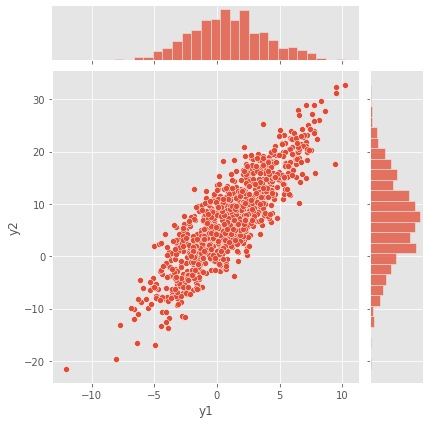

In [13]:
sns.jointplot(x=data['y1'], y=data['y2'])

In [14]:
dataset = make_dataset_from_df(data, target_names=['y1', 'y2'], format_features_as='dict')
dataset

<TensorSliceDataset shapes: ((2,), (2,)), types: (tf.float32, tf.float32)>

In [15]:
features, targets = list(dataset.batch(dataset.cardinality()).take(1))[0]
targets.shape

TensorShape([1000, 2])

## 2. Model

In [16]:
class MVNCholPrecisionTriL(tfd.TransformedDistribution):
    """MVN from loc and (Cholesky) precision matrix."""

    def __init__(self, loc, chol_precision_tril, name=None):
        super(MVNCholPrecisionTriL, self).__init__(
            distribution=tfd.Independent(tfd.Normal(tf.zeros_like(loc),
                                                    scale=tf.ones_like(loc)),
                                         reinterpreted_batch_ndims=1),
            bijector=tfb.Chain([
                tfb.Shift(shift=loc),
                tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=chol_precision_tril,
                                               adjoint=True)),
            ]),
            name=name)

In [32]:
priors = OrderedDict(
    loc = tfd.MultivariateNormalDiag(loc=[0.]*dims, scale_diag=[10.]*dims),
    precision = tfd.WishartTriL(
        df=5,
        scale_tril=tf.constant(10.0*tf.eye(dims)),
        input_output_cholesky=True
    )
)

def likelihood(loc, precision): 
    return tfd.MultivariateNormalTriL(
        loc=loc, scale_tril=tf.linalg.cholesky_solve(
            precision, tf.linalg.eye(dims)
        )
    )
    #return MVNCholPrecisionTriL(loc=loc, chol_precision_tril=precision)

constraining_bijectors = [
    tfb.Identity(),
    tfb.FillScaleTriL(diag_bijector=tfb.Softplus(), diag_shift=1e-3)
]

In [33]:
model = Model(priors=priors, likelihood=likelihood, constraining_bijectors=constraining_bijectors)

In [34]:
def get_continuous_flow_bijector(unconstrained_event_dims):
    state_fn = tfk.Sequential()
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(unconstrained_event_dims))
    state_fn.build((None, unconstrained_event_dims+1))
    state_time_derivative_fn = lambda t, state: state_fn(tf.concat([tf.fill((state.shape[0],1), t), state], axis=-1))
    return tfb.FFJORD(state_time_derivative_fn, 
                      ode_solve_fn=tfp.math.ode.DormandPrince(first_step_size=0.1).solve, 
                      trace_augmentation_fn=tfb.ffjord.trace_jacobian_hutchinson)
    
def get_hamiltonian_flow_bijector(unconstrained_event_dims, num_flows):
    return tfb.Chain([
        HamiltonianFlow(
            event_dims=unconstrained_event_dims,
            symplectic_integrator=LeapfrogIntegrator(), 
            step_sizes=tf.Variable(0.1), 
            num_integration_steps=2,
            hidden_layers=[128, 128]
        ) for _ in range(num_flows)
    ])

def get_masked_autoregressive_flow_bijector(unconstrained_event_dims):
    return tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, hidden_units=[32, 32], activation='relu')
    )

def get_affine_flow_bijector(unconstrained_event_dims):
    return AffineFlow(unconstrained_event_dims)


In [85]:
advi = ADVI(model, mean_field=False)
scale_fn = make_scale_fn(model.flat_unconstrained_param_event_ndims, hidden_layers=[128,128])
shift_fn = make_shift_fn(model.flat_unconstrained_param_event_ndims, hidden_layers=[128,128])

posterior_lift = lambda q: tfd.MultivariateNormalDiag(loc=shift_fn(q), scale_diag=scale_fn(q))
nf = NormalizingFlow(
    model, 
    get_hamiltonian_flow_bijector(model.flat_unconstrained_param_event_ndims, 2),
    extra_ndims=model.flat_unconstrained_param_event_ndims,
    posterior_lift_distribution=posterior_lift
)
affine = NormalizingFlow(
    model, 
    get_affine_flow_bijector(model.flat_unconstrained_param_event_ndims)
)

In [87]:
vi = VI(model, dataset, nf)
optimizer = tf.optimizers.Adam(learning_rate=1e-3)

In [88]:
approx_posterior, losses = vi.fit(num_steps=5000, sample_size=50)
#approx_posterior, losses = vi.stochastic_fit(epochs=50, batch_size=10, sample_size=10)

In [89]:
locs, precision = approx_posterior.sample(10000).values()

In [90]:
tf.reduce_mean(locs, axis=0), tf.reduce_mean(precision, axis=0)

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9130706, 7.062258 ], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[11.517151  ,  0.        ],
        [-8.23707   ,  0.41338673]], dtype=float32)>)

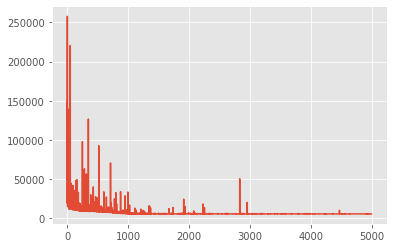

In [91]:
plt.plot(losses)

In [112]:
post_pred_dist = model.get_posterior_predictive_distribution(posterior_distribution=approx_posterior)
post_pred_samples = post_pred_dist.sample(10000)
preds = pd.DataFrame({'y{}'.format(i+1): y_i for i, y_i in enumerate(tf.unstack(post_pred_samples['y'], axis=1))})
preds.head()

,y1,y2
0,-0.503503,-1.877963
1,-0.635489,2.892369
2,3.868650,4.898639
3,0.549791,1.139723
4,-5.760048,-0.710527


In [113]:
preds.mean()

y1    0.877260
y2    6.955205
dtype: float32

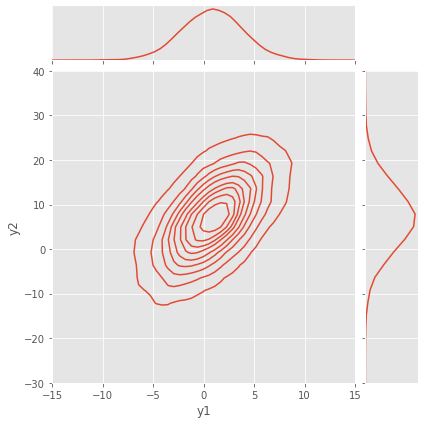

In [115]:
sns.jointplot(x=preds['y1'], y=preds['y2'], kind='kde', xlim=(-15,15), ylim=(-30,40))

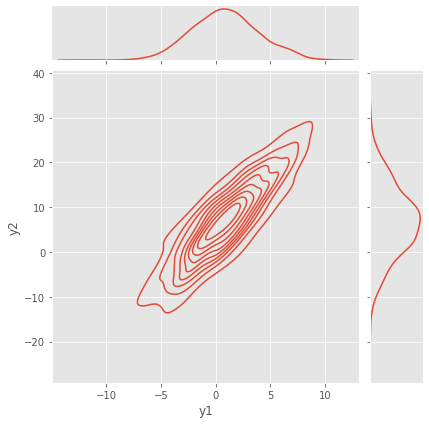

In [94]:
sns.jointplot(x=data['y1'], y=data['y2'], kind='kde')

## MCMC

In [63]:
# sampling params
NUM_CHAINS = 5
NUM_SAMPLES = 1000
NUM_BURNIN_STEPS = 10000

In [64]:
# define step size adaptation
stepsize_adaptation_kernel = DualAveragingStepSizeAdaptation(num_adaptation_steps=int(NUM_BURNIN_STEPS*0.8))

kernel = NoUTurnSampler(
    step_size=0.01, 
    max_tree_depth=5,
    stepsize_adaptation_kernel=stepsize_adaptation_kernel
)

In [65]:
mcmc = MCMC(model, dataset, transition_kernel=kernel)

In [66]:
result = mcmc.fit(progress_bar=True)

In [71]:
tf.linalg.inv([tf.reduce_mean(x, axis=0) for x in result.samples][1])

<tf.Tensor: shape=(4, 2, 2), dtype=float32, numpy=
array([[[0.06324089, 0.        ],
        [1.6672438 , 2.3452184 ]],

       [[0.05153861, 0.        ],
        [1.667568  , 2.343967  ]],

       [[0.07699121, 0.        ],
        [1.6663965 , 2.344279  ]],

       [[0.0856859 , 0.        ],
        [1.6655704 , 2.3452485 ]]], dtype=float32)>

In [68]:
post_pred_dist = model.get_posterior_predictive_distribution(
    posterior_samples=result.samples,
)
posterior_predictive_samples = post_pred_dist.sample(10000)['y'].numpy()

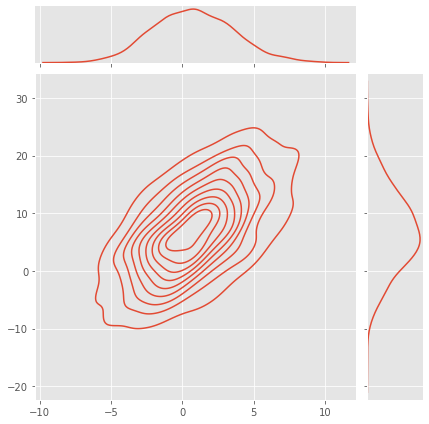

In [70]:
sns.jointplot(x=posterior_predictive_samples[:,0], y=posterior_predictive_samples[:,1], kind='kde')